In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import modin.pandas as pd
import matplotlib.pyplot as plt

### Set hyperparameters

In [5]:
output_dir = 'model_output/gru'

# training
EPOCHS = 4
BATCH_SIZE = 128

# vector-space embedding
N_DIM = 64
N_UNIQUE_WORDS = 10000
MAX_REVIEW_LENGTH = 100 # we lower due to vanishing gradient over time
PAD_TYPE = TRUNC_TYPE = 'pre'
DROP_EMBED = 0.2 # this is for Embedding Layer

# RNN layer architecture
N_GRU = 256 # filters a.k.a. kernels
DROP_GRU = 0.2


## Dense Layer genellikle kullanilmaz RNN'den sonra ama ConV'dan sonra kullanilir
# neural network architecture
# N_DENSE = 256
# DROPOUT = 0.2

In [6]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words = N_UNIQUE_WORDS)

### Preprocess

In [7]:
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

X_valid = pad_sequences(X_valid, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

### GRU Architecture

In [8]:
model = Sequential()

# first hidden layer --> Embedding Layer
model.add(Embedding(N_UNIQUE_WORDS, N_DIM, input_length=MAX_REVIEW_LENGTH))
model.add(SpatialDropout1D(DROP_EMBED))


# second hidden layer --> Dense Layer
model.add(GRU(N_GRU, dropout=DROP_GRU)) # image icin Conv2D kullanilir

# third hidden layer --> Dense Layer
# model.add(Dense(N_DENSE, activation='relu'))
# model.add(Dropout(DROPOUT))


# output layer
model.add(Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
gru (GRU)                    (None, 256)               247296    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 887,553
Trainable params: 887,553
Non-trainable params: 0
_________________________________________________________________


### Compile Model

In [10]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [11]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [12]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train Model

In [13]:
model.fit(X_train, y_train,
         batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
         validation_data=(X_valid, y_valid),
         callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.6312 - accuracy: 0.6533 - val_loss: 0.4792 - val_accuracy: 0.7707
Epoch 2/4
25000/25000 [==============================] - 50s 2ms/sample - loss: 0.3572 - accuracy: 0.8432 - val_loss: 0.5007 - val_accuracy: 0.8181
Epoch 3/4
25000/25000 [==============================] - 51s 2ms/sample - loss: 0.2805 - accuracy: 0.8864 - val_loss: 0.3511 - val_accuracy: 0.8469
Epoch 4/4
25000/25000 [==============================] - 48s 2ms/sample - loss: 0.2360 - accuracy: 0.9075 - val_loss: 0.3520 - val_accuracy: 0.8450


In [46]:
# best one is 3rd epoch

In [14]:
model.load_weights(output_dir+"/weights.03.hdf5")

### Evaluate

In [15]:
y_pred = model.predict_proba(X_valid)

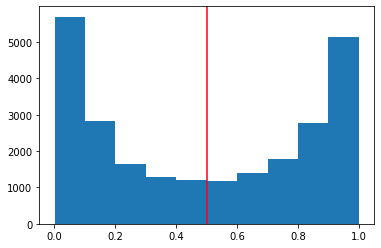

In [16]:
plt.hist(y_pred)
_ = plt.axvline(0.5, color='red')

In [17]:
pct_auc = roc_auc_score(y_valid, y_pred)*100.0
print(pct_auc)

92.51273791999999
